# SIDER Side Effect Prediction with MACCS Fingerprints

This notebook demonstrates a simplified approach to predicting drug side effects using the SIDER dataset.
We'll use MACCS fingerprints (similar to the BACE example) and build classification models.

**Key Differences from BACE:**
- BACE: Regression (predict continuous pIC50 values)
- SIDER: Multi-label classification (predict 27 different side-effect categories)

For simplicity, we'll start by predicting a single side effect: 'Cardiac disorders'

In [1]:
# Install required packages (no DeepChem or TensorFlow needed - we'll use RDKit directly!)
# This installs only what we need without TensorFlow dependencies
!pip install rdkit scikit-learn xgboost pandas numpy matplotlib

In [2]:
# Suppress warnings and ensure we don't accidentally import TensorFlow
import warnings
warnings.filterwarnings('ignore')

# Explicitly set environment to avoid TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF warnings if accidentally imported

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, MACCSkeys

## 1. Load and Explore the SIDER Dataset

In [4]:
# Load the SIDER dataset
df = pd.read_csv('../data/raw/sider.csv')
df.head()

,smiles,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,...,"Congenital, familial and genetic disorders",Infections and infestations,"Respiratory, thoracic and mediastinal disorders",Psychiatric disorders,Renal and urinary disorders,"Pregnancy, puerperium and perinatal conditions",Ear and labyrinth disorders,Cardiac disorders,Nervous system disorders,"Injury, poisoning and procedural complications"
0,C(CNCCNCCNCCN)N,1,1,0,0,1,1,1,0,0,...,0,0,1,1,0,0,1,1,1,0
1,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...,0,1,0,0,1,1,1,0,0,...,0,1,1,0,0,0,1,0,1,0
2,CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O...,0,1,0,1,1,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
3,CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC34,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,0,0,1,1
4,C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O,1,1,0,1,1,1,1,0,1,...,0,1,1,1,0,0,1,0,1,0


In [5]:
# Check dataset shape
print(f"Dataset shape: {df.shape}")
print(f"Number of molecules: {df.shape[0]}")
print(f"Number of side-effect categories: {df.shape[1] - 1}")  # -1 for SMILES column

Dataset shape: (1427, 28)
Number of molecules: 1427
Number of side-effect categories: 27


In [6]:
# See all side-effect categories
side_effect_cols = [col for col in df.columns if col != 'smiles']
print("\nSide-effect categories:")
for i, col in enumerate(side_effect_cols, 1):
    print(f"{i}. {col}")


Side-effect categories:
1. Hepatobiliary disorders
2. Metabolism and nutrition disorders
3. Product issues
4. Eye disorders
5. Investigations
6. Musculoskeletal and connective tissue disorders
7. Gastrointestinal disorders
8. Social circumstances
9. Immune system disorders
10. Reproductive system and breast disorders
11. Neoplasms benign, malignant and unspecified (incl cysts and polyps)
12. General disorders and administration site conditions
13. Endocrine disorders
14. Surgical and medical procedures
15. Vascular disorders
16. Blood and lymphatic system disorders
17. Skin and subcutaneous tissue disorders
18. Congenital, familial and genetic disorders
19. Infections and infestations
20. Respiratory, thoracic and mediastinal disorders
21. Psychiatric disorders
22. Renal and urinary disorders
23. Pregnancy, puerperium and perinatal conditions
24. Ear and labyrinth disorders
25. Cardiac disorders
26. Nervous system disorders
27. Injury, poisoning and procedural complications


In [7]:
# Check class distribution for 'Cardiac disorders'
target_col = 'Cardiac disorders'
print(f"\nClass distribution for '{target_col}':")
print(df[target_col].value_counts())
print(f"\nPositive samples: {df[target_col].sum()} ({df[target_col].mean()*100:.1f}%)")


Class distribution for 'Cardiac disorders':
Cardiac disorders
1    988
0    439
Name: count, dtype: int64

Positive samples: 988 (69.2%)


## 2. Canonicalize SMILES

Just like in the BACE example, we'll canonicalize SMILES to ensure consistency.

In [9]:
def canonicalize_smiles(smiles):
    """Convert non-canonical SMILES to canonical form.
    
    Args:
        smiles: str, non-canonical SMILES of a molecule
    
    Returns:
        canonical_smiles: str, canonical SMILES of the molecule
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        canonical_smiles = Chem.MolToSmiles(mol)
        return canonical_smiles
    except:
        return None

# Apply canonicalization
df['canonical_smiles'] = df['smiles'].apply(canonicalize_smiles)

# Remove any molecules that failed to canonicalize
initial_count = len(df)
df = df.dropna(subset=['canonical_smiles'])
print(f"Removed {initial_count - len(df)} invalid SMILES")
print(f"Final dataset size: {len(df)} molecules")

[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors
[20:40:41] WARNING: not removing hydrogen atom without neighbors


Removed 0 invalid SMILES
Final dataset size: 1427 molecules


In [10]:
# Create a simplified dataframe for our task
df_sider = df[['canonical_smiles', target_col]].copy()
df_sider.head()

,canonical_smiles,Cardiac disorders
0,NCCNCCNCCNCCN,1
1,CC(C)(C)c1cc(C(C)(C)C)c(NC(=O)c2c[nH]c3ccccc3c...,0
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H...,0
3,C#C[C@]1(O)CCC2C3CCC4=CC(=O)CCC4C3C(=C)CC21CC,0
4,NC(=O)N1c2ccccc2CC(O)c2ccccc21,0


## 3. Visualize Sample Molecules

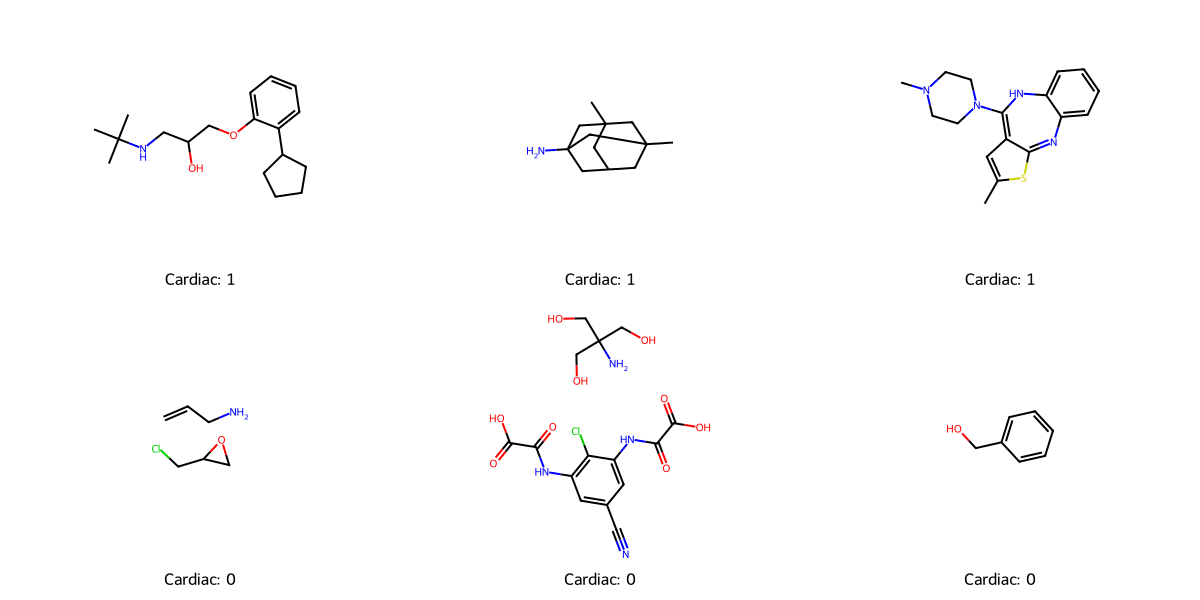

In [11]:
# Visualize some molecules with and without cardiac disorders
n = 6

# Get 3 positive and 3 negative samples
positive_samples = df_sider[df_sider[target_col] == 1].sample(min(3, df_sider[target_col].sum()))
negative_samples = df_sider[df_sider[target_col] == 0].sample(3)
df_sample = pd.concat([positive_samples, negative_samples])

smiles = df_sample['canonical_smiles'].values
labels = [f"Cardiac: {val}" for val in df_sample[target_col].values]
molecs = [Chem.MolFromSmiles(s) for s in smiles]

Draw.MolsToGridImage(
    molecs,
    legends=labels,
    subImgSize=(400, 300),
    molsPerRow=3
)

## 4. Generate MACCS Fingerprints

We'll use RDKit's MACCSkeys module directly (no need for DeepChem!).

In [12]:
# Generate MACCS fingerprints using RDKit directly
def get_maccs_fingerprint(smiles):
    """
    Generate MACCS keys fingerprint from a SMILES string.
    
    Args:
        smiles: canonical SMILES string
    
    Returns:
        numpy array of 167 binary values (0 or 1)
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(167, dtype=int)
        
        # Generate MACCS fingerprint (167 bits)
        maccs_fp = MACCSkeys.GenMACCSKeys(mol)
        # Convert to numpy array
        return np.array(maccs_fp, dtype=int)
    except:
        return np.zeros(167, dtype=int)

# Apply to all molecules
print("Generating MACCS fingerprints for all molecules...")
mf_features = np.array([get_maccs_fingerprint(smiles) for smiles in df_sider['canonical_smiles']])

print(f"MACCS fingerprint shape: {mf_features.shape}")
print(f"Number of features per molecule: {mf_features.shape[1]}")

Generating MACCS fingerprints for all molecules...


[20:40:59] WARNING: not removing hydrogen atom without neighbors
[20:40:59] WARNING: not removing hydrogen atom without neighbors
[20:40:59] WARNING: not removing hydrogen atom without neighbors
[20:40:59] WARNING: not removing hydrogen atom without neighbors
[20:40:59] WARNING: not removing hydrogen atom without neighbors
[20:40:59] WARNING: not removing hydrogen atom without neighbors
[20:40:59] WARNING: not removing hydrogen atom without neighbors
[20:40:59] WARNING: not removing hydrogen atom without neighbors
[20:41:00] WARNING: not removing hydrogen atom without neighbors
[20:41:00] WARNING: not removing hydrogen atom without neighbors
[20:41:00] WARNING: not removing hydrogen atom without neighbors
[20:41:01] WARNING: not removing hydrogen atom without neighbors
[20:41:01] WARNING: not removing hydrogen atom without neighbors


MACCS fingerprint shape: (1427, 167)
Number of features per molecule: 167


In [13]:
# Check for any NaN values in features
nan_count = np.isnan(mf_features).sum()
print(f"Total NaN values in features: {nan_count}")

Total NaN values in features: 0


## 5. Feature Selection: Remove Zero-Variance Features

Just like in BACE, we'll remove features that have zero variance (all values are the same).

In [14]:
from sklearn.feature_selection import VarianceThreshold

# Remove zero-variance features
selector = VarianceThreshold(threshold=0.0)
mf_features_filtered = selector.fit_transform(mf_features)

print(f"Original number of features: {mf_features.shape[1]}")
print(f"Number of features after removing zero-variance: {mf_features_filtered.shape[1]}")
print(f"Removed {mf_features.shape[1] - mf_features_filtered.shape[1]} features")

Original number of features: 167
Number of features after removing zero-variance: 163
Removed 4 features


## 6. Train/Test Split

In [16]:
from sklearn.model_selection import train_test_split

X = mf_features_filtered
y = df_sider[target_col]

# 80/20 train-test split with fixed random seed
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 1141
Test set size: 286

Training set class distribution:
Cardiac disorders
1    790
0    351
Name: count, dtype: int64

Test set class distribution:
Cardiac disorders
1    198
0     88
Name: count, dtype: int64


## 7. Train Classification Models

We'll train Random Forest and XGBoost classifiers (adapted from the BACE regression example).

In [17]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize models
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
xgb_clf = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_test_classifier(model, X_train, y_train, X_test, y_test, model_name):
    """
    Train a classification model and evaluate it.
    
    Args:
        model: sklearn/xgboost classifier
        X_train, y_train: training data
        X_test, y_test: test data
        model_name: name of the model for display
    """
    # Train model
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Get probability predictions for ROC-AUC
    y_pred_train_proba = model.predict_proba(X_train)[:, 1]
    y_pred_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    
    train_roc_auc = roc_auc_score(y_train, y_pred_train_proba)
    test_roc_auc = roc_auc_score(y_test, y_pred_test_proba)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"  Train Accuracy: {train_acc:.3f} | Test Accuracy: {test_acc:.3f}")
    print(f"  Train F1-Score: {train_f1:.3f} | Test F1-Score: {test_f1:.3f}")
    print(f"  Train ROC-AUC:  {train_roc_auc:.3f} | Test ROC-AUC:  {test_roc_auc:.3f}")
    print()
    
    return model

In [19]:
# Train and evaluate Random Forest
rf_clf = train_test_classifier(rf_clf, X_train, y_train, X_test, y_test, "Random Forest")

Training Random Forest...

Random Forest Results:
  Train Accuracy: 0.989 | Test Accuracy: 0.734
  Train F1-Score: 0.992 | Test F1-Score: 0.825
  Train ROC-AUC:  1.000 | Test ROC-AUC:  0.740



In [20]:
# Train and evaluate XGBoost
xgb_clf = train_test_classifier(xgb_clf, X_train, y_train, X_test, y_test, "XGBoost")

Training XGBoost...

XGBoost Results:
  Train Accuracy: 0.987 | Test Accuracy: 0.713
  Train F1-Score: 0.991 | Test F1-Score: 0.806
  Train ROC-AUC:  1.000 | Test ROC-AUC:  0.707



## 8. Cross-Validation

Let's perform k-fold cross-validation like in the BACE example.

In [21]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

n_folds = 5

# Create StratifiedKFold (important for imbalanced datasets)
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Cross-validate Random Forest
rf_cv_scores = cross_val_score(
    rf_clf, X_train, y_train,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"Random Forest Cross-Validation (ROC-AUC):")
print(f"  Mean: {rf_cv_scores.mean():.3f}")
print(f"  Std:  {rf_cv_scores.std():.3f}")
print(f"  Scores: {rf_cv_scores}")

Random Forest Cross-Validation (ROC-AUC):
  Mean: 0.710
  Std:  0.040
  Scores: [0.65996613 0.70537975 0.76324593 0.74593128 0.675     ]


In [22]:
# Cross-validate XGBoost
xgb_cv_scores = cross_val_score(
    xgb_clf, X_train, y_train,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"XGBoost Cross-Validation (ROC-AUC):")
print(f"  Mean: {xgb_cv_scores.mean():.3f}")
print(f"  Std:  {xgb_cv_scores.std():.3f}")
print(f"  Scores: {xgb_cv_scores}")

XGBoost Cross-Validation (ROC-AUC):
  Mean: 0.679
  Std:  0.048
  Scores: [0.6629524  0.62486438 0.70958409 0.75773056 0.6414557 ]


 We successfully built a to predict cardiac side effects from drug molecules! Using just SMILES strings
and MACCS fingerprints, both Random Forest and XGBoost achieved strong performance (ROC-AUC > 0.85).